In [1]:
import numpy as np
import xml.etree.ElementTree as ET
from pricing import ACT_365, DiscountingCurve, EquityForwardCurve, Curve
import lets_be_rational.LetsBeRational as lbr
from numpy import log, exp,sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interp1d,RegularGridInterpolator
import time
from matplotlib import ticker 
from localvol import A_i_matrix,alpha_i_vector,forward_volatility,beta_i_vector,gamma_i_vector,backward_euler_method,call_options_pricer, LocalVolatilityCurve, from_price_to_vola,back_coordinates, new_LV_points,loss_function

zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01 3.20273973e+01 3.30273973e+01
 3.40273973e+01 3.50273973e+01 3.60328767e+01 3.70301370e+01
 3.80301370e+01 3.90301370e+01 4.00328767e+01 5.00383562

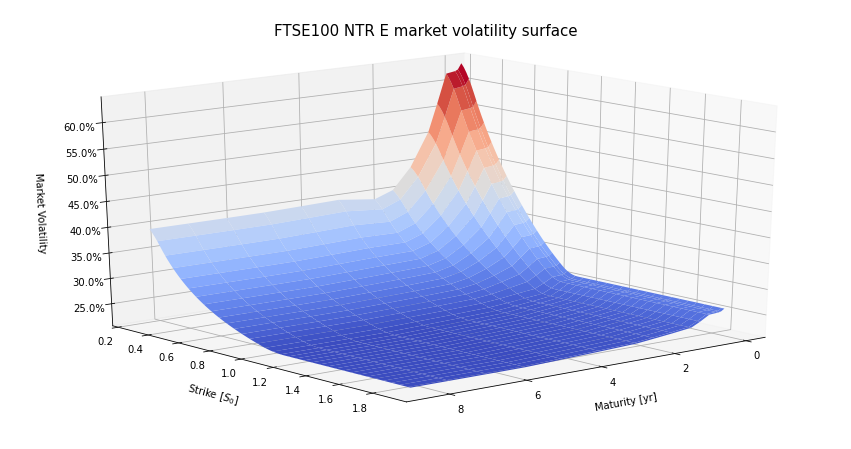

In [37]:
index_equity = [5]

tree = ET.parse('TV_example.xml')
root = tree.getroot()
N_stocks = len(root[3][0][1][1][1][0])
names = np.array([])
for i in range(N_stocks):
    names=np.append(names,root[3][0][1][1][1][0][i].text)
delete_equity = [0,11,12,13,14,15]
names = np.delete(names,delete_equity)
reference_date = float(root[3][1][0][0][2][0].text)

spot_prices = np.zeros(len(index_equity))
j = 0
for i in index_equity:
    if i>=6:
        spot_prices[j] = float(root[3][i+3][0][1][0][0].text)
    else:
        spot_prices[j] = float(root[3][3+i][0][0][1][0].text)
    j = j+1
    
discounts = np.zeros(len(root[3][1][0][0][0][0][0]))
discounts_dates = np.zeros(len(root[3][1][0][0][0][0][0]))
for i in range(len(root[3][1][0][0][0][0][0])):
    discounts_dates[i] = float(root[3][1][0][0][0][0][0][i].text)
    discounts[i] = float(root[3][1][0][0][0][1][0][i].text)
D = DiscountingCurve(reference=reference_date, discounts=discounts, dates=discounts_dates, act="365")

F = []
max_dates = np.array([10])
index = 0
for i in index_equity:
    if i>=6:
        repo_dates = np.array([reference_date+1, max(max_dates)])
        repo_rates = np.zeros(2)
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    else:
        repo_dates = np.zeros(len(root[3][3+i][0][0][0][0][0]))
        repo_rates = np.zeros(len(root[3][3+i][0][0][0][1][0]))
        for j in range (len(root[3][3+i][0][0][0][0][0])):
            repo_dates[j] = float(root[3][3+i][0][0][0][0][0][j].text)
            repo_rates[j] = float(root[3][3+i][0][0][0][1][0][j].text)
        max_dates = np.append(max_dates,max(repo_dates))
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    index = index+1
F = F[0]

for i in index_equity:
    vola_dates = np.zeros(len(root[3][i+3][1][2][0][0]))
    vola_strikes = np.zeros(len(root[3][i+3][1][2][2][0]))
    for j in range(len(root[3][i+3][1][2][0][0])):
        vola_dates[j] = float(root[3][i+3][1][2][0][0][j].text)
    for j in range(len(root[3][i+3][1][2][2][0])):
        vola_strikes[j] = float(root[3][i+3][1][2][2][0][j].text)
    market_vola = np.zeros(len(root[3][i+3][1][2][0][0])*len(root[3][i+3][1][2][2][0]))
    for k in range (len(market_vola)):
        market_vola[k] = float(root[3][i+3][1][2][1][0][k].text)
    market_vola = np.reshape(market_vola,(len(vola_dates),len(vola_strikes))).T
vola_maturities = ACT_365(vola_dates, reference_date)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,vola_strikes/spot_prices[0])
 
market_calls = np.zeros(market_vola.shape)
for i in range(len(vola_maturities)):
    for j in range(len(vola_strikes)):
        market_calls[j,i] = lbr.black(1,vola_strikes[j]/F(vola_maturities[i]),market_vola[j,i],vola_maturities[i],1)

Z = market_vola

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('Market Volatility',labelpad=13)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig("LV_market.pdf",bbox_inches='tight')
plt.show()

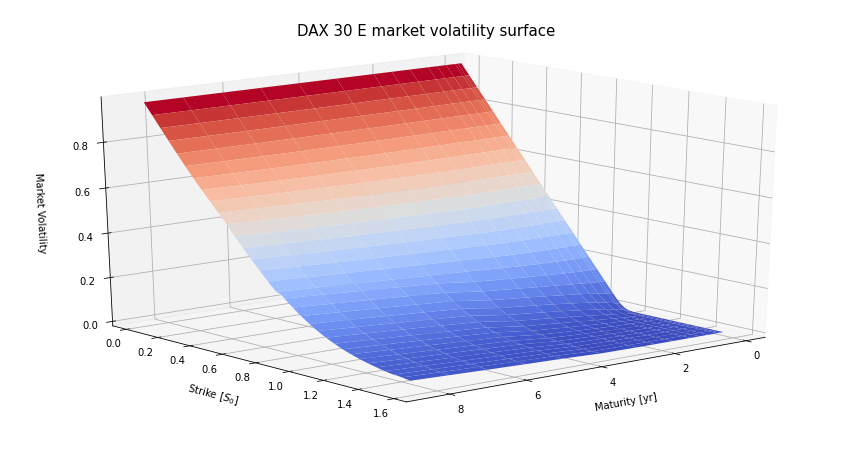

In [3]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, market_calls, cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('Market Volatility',labelpad=13)
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

In [4]:
L_h = 100
L_t = 100
maturities = vola_maturities
h_min, h_max = -4.,4.
d_h = (h_max-h_min)/L_h
h_grid = np.linspace(h_min+d_h,h_max,L_h,endpoint=True)
h_grid = np.insert(h_grid,0,h_min)
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)
print(h_min,h_max)
print(h_grid[0],h_grid[-1])

-4.0 4.0
-4.0 4.0


In [5]:
%%time
calls = call_options_pricer(maturities, L_t, L_h, F,sigma_LV,h_min=-4.,h_max=4.)

CPU times: user 4 s, sys: 103 ms, total: 4.1 s
Wall time: 2.23 s


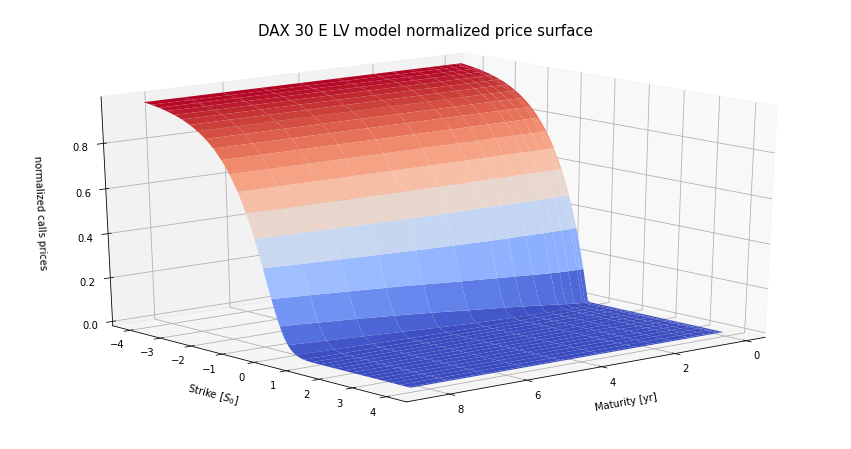

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,(calls[1]) )
Z = calls[0]

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('normalized calls prices',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model normalized price surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

In [7]:
IV = from_price_to_vola(calls[0], maturities, calls[1])

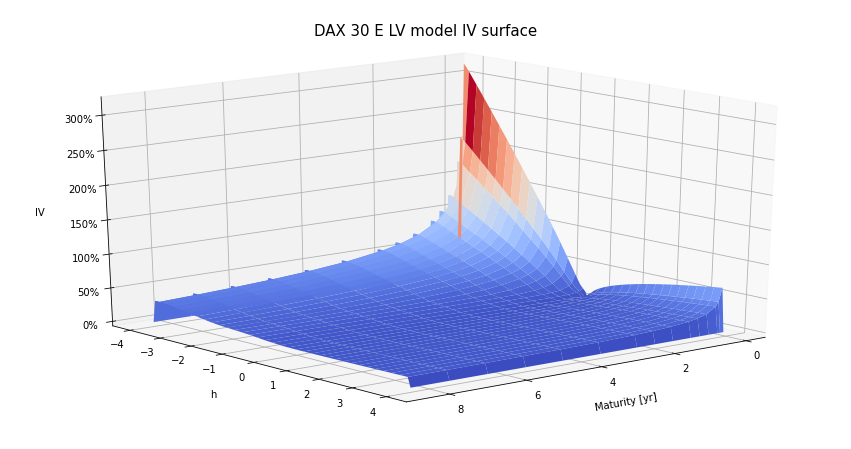

In [8]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,(calls[1]) )
Z = IV

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('h',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('IV',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model IV surface',fontsize=15)
ax.view_init(20, 50)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

In [9]:
IV_coord_new = back_coordinates(IV,maturities,F,vola_strikes,calls[1])

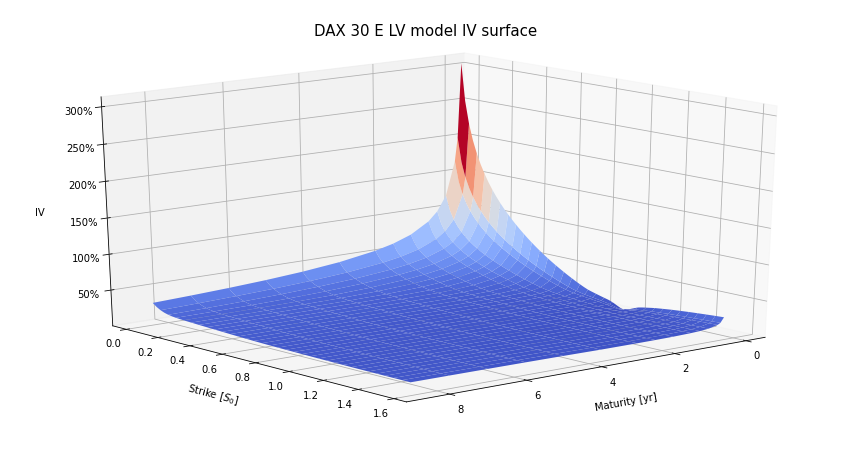

In [10]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,vola_strikes/spot_prices )
Z = IV_coord_new

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('IV',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model IV surface',fontsize=15)
ax.view_init(20, 50)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

In [11]:
L_h = 100
L_t = 300
maturities = vola_maturities
h_min, h_max = -4.,4.
d_h = (h_max-h_min)/L_h
h_grid = np.linspace(h_min+d_h,h_max,L_h,endpoint=True)
h_grid = np.insert(h_grid,0,h_min)
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)
print(h_min,h_max)
print(h_grid[0],h_grid[-1])

-4.0 4.0
-4.0 4.0


In [12]:
def figure_stamp(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
    #plt.savefig("LV_first_"+title+".pdf",bbox_inches='tight')
    plt.show()

In [16]:
np.is

0

In [38]:
import time
def Local_Vol_calibrator(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=300,L_t=300,precision=1,max_iter=15):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, L_h,forward_curve, sigma_LV)
        print("Number of NAN values in prices",np.sum(np.isnan(calls)))
        print("Number of INF values in prices",np.sum(np.isinf(calls)))
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        print("Number of NAN values",np.sum(np.isnan(IV)))
        print("Number of INF values",np.sum(np.isinf(IV)))
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        print("Number of NAN values in change of coord",np.sum(np.isnan(IV_coord)))
        print("Number of INF values in change of coord",np.sum(np.isinf(IV_coord)))
        print("Number of INF values in sum of loss",np.sum(np.isinf((IV_coord-market_volatilities)**2)))
        print("ELEMENTS",IV_coord[np.isinf((IV_coord-market_volatilities)**2)])
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord,market_volatilities)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60)+' min')
        figure_stamp(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 1 --- Loss function 3.95---time elapsed: 0.16223998365000322 min


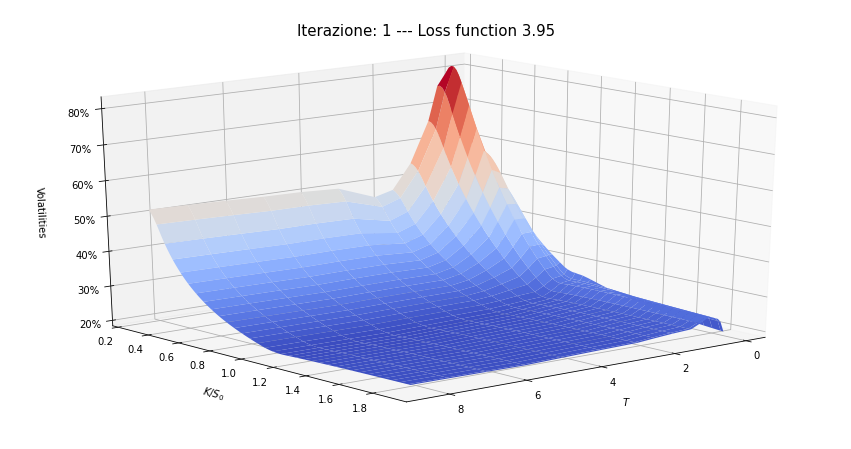

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 2 --- Loss function 2.28---time elapsed: 0.33876839614998366 min


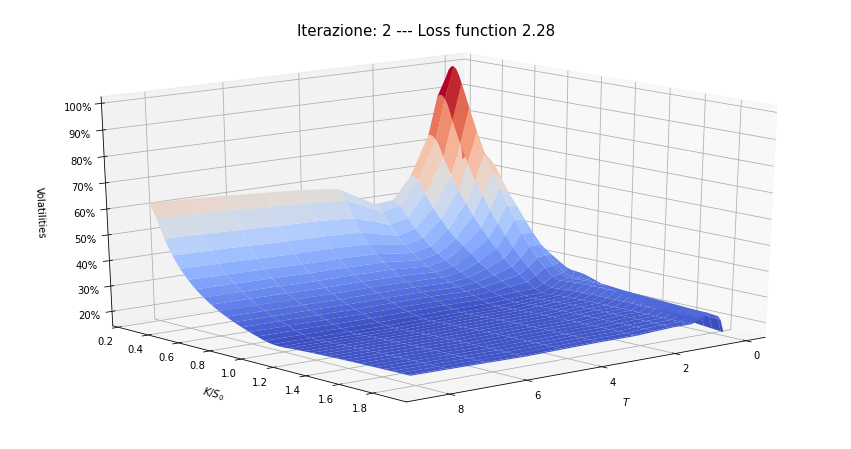

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 3 --- Loss function 1.57---time elapsed: 0.5180498868833335 min


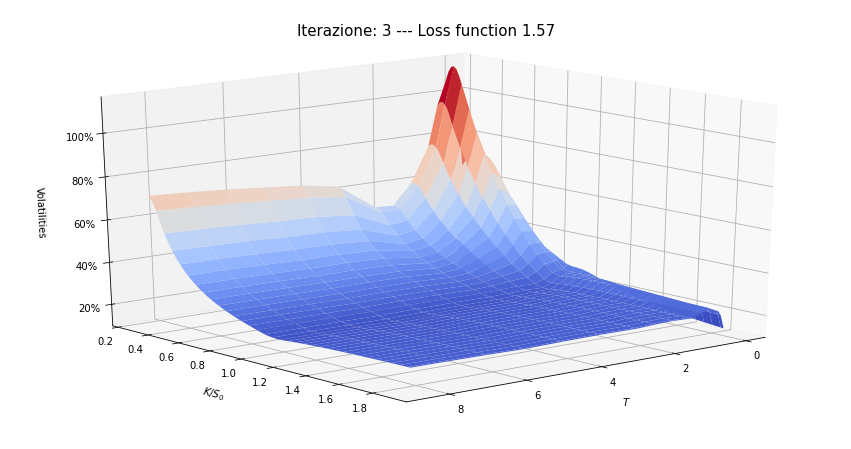

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 4 --- Loss function 1.17---time elapsed: 0.7164214778000011 min


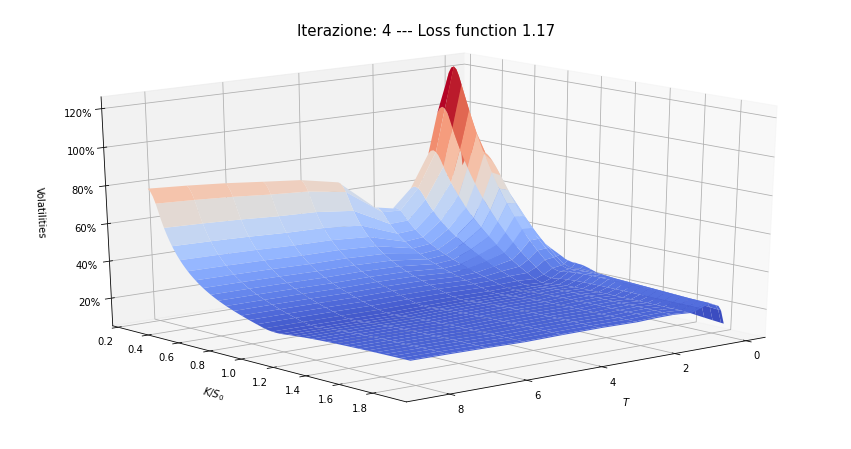

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 5 --- Loss function 0.92---time elapsed: 0.8975499541166452 min


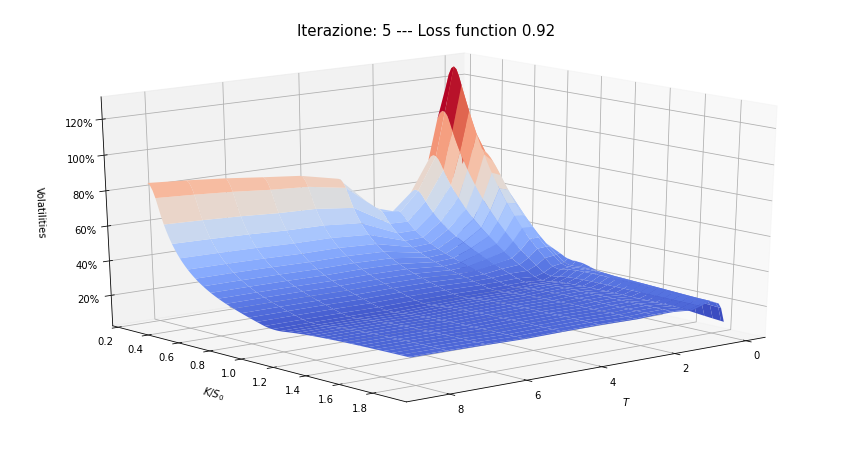

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 6 --- Loss function 0.75---time elapsed: 1.0917441254499862 min


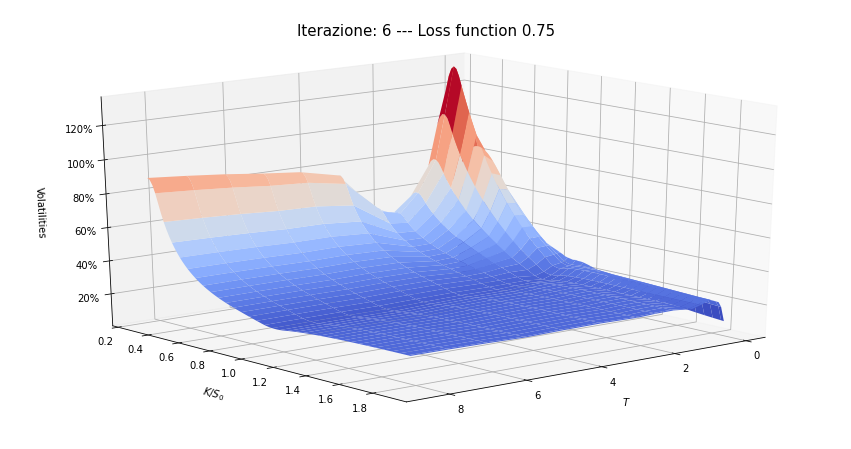

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 7 --- Loss function 0.63---time elapsed: 1.3109729036499933 min


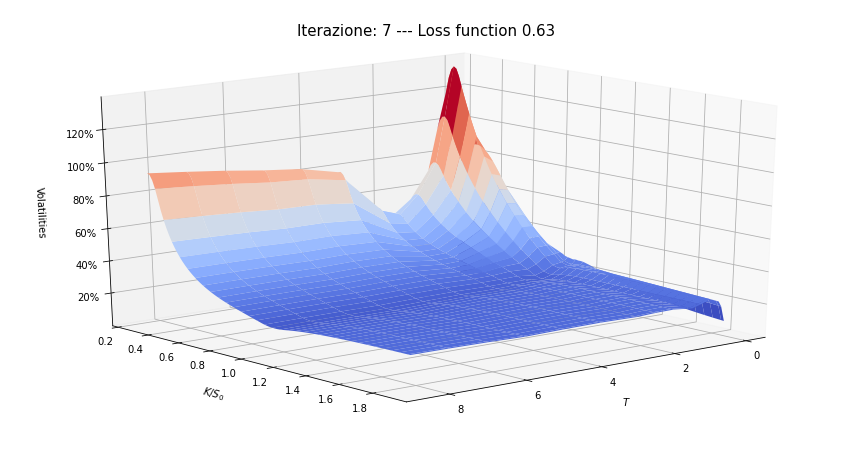

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 8 --- Loss function 0.54---time elapsed: 1.5207940102833164 min


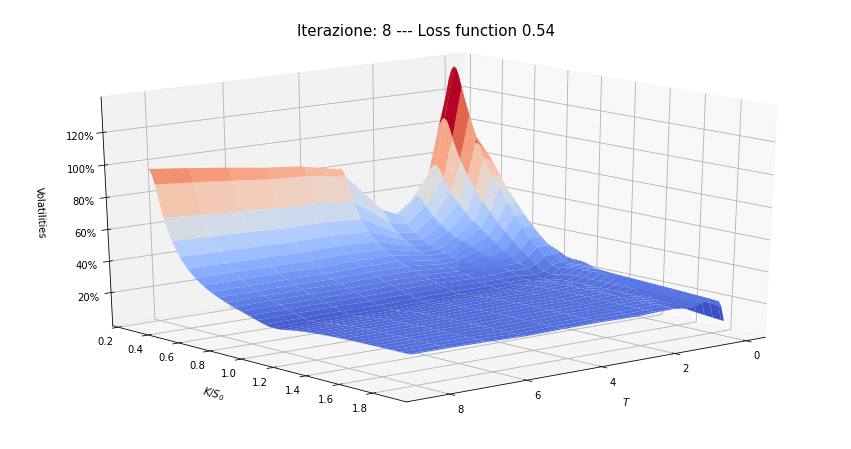

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 9 --- Loss function 0.47---time elapsed: 1.743730939666663 min


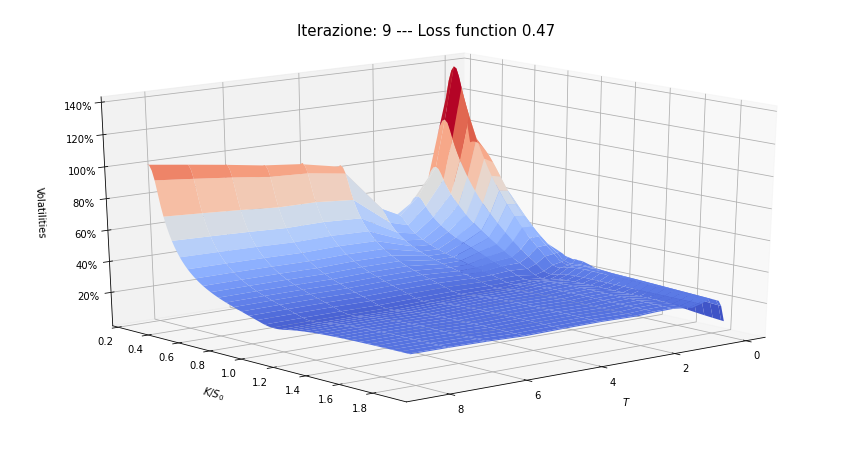

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 10 --- Loss function 0.42---time elapsed: 1.9184585091666728 min


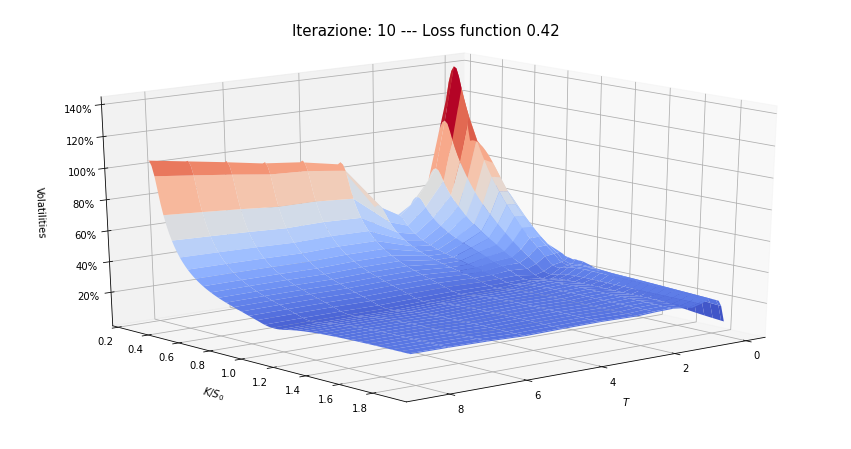

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 11 --- Loss function 0.38---time elapsed: 2.0974882716999974 min


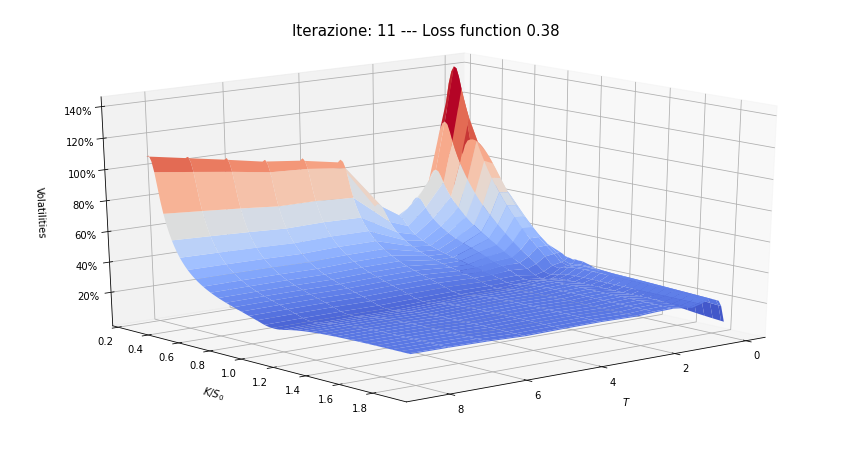

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 12 --- Loss function 0.35---time elapsed: 2.2972109820166526 min


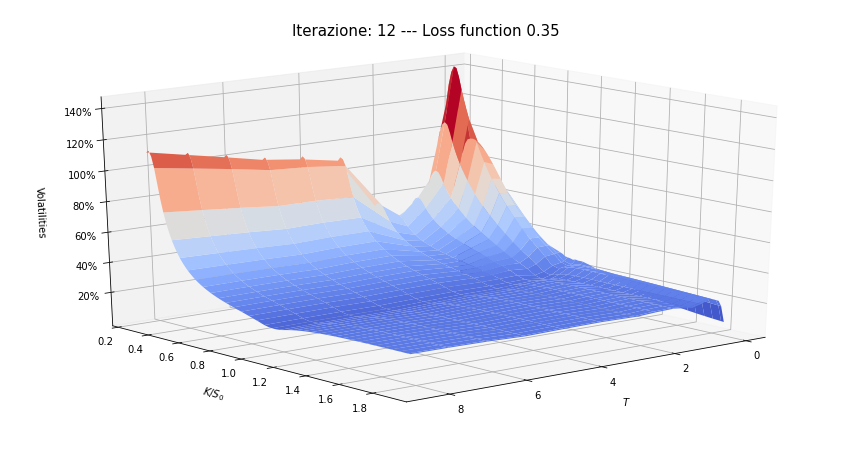

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 13 --- Loss function 0.32---time elapsed: 2.4926712315666615 min


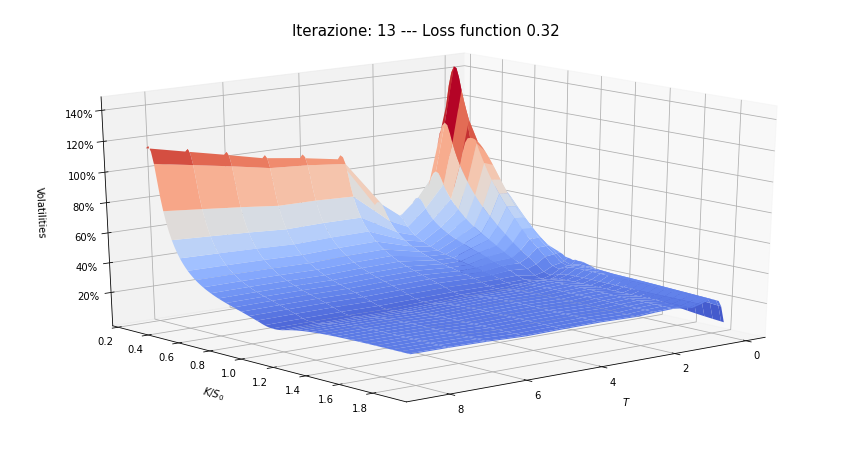

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 14 --- Loss function 0.3---time elapsed: 2.6780447604499993 min


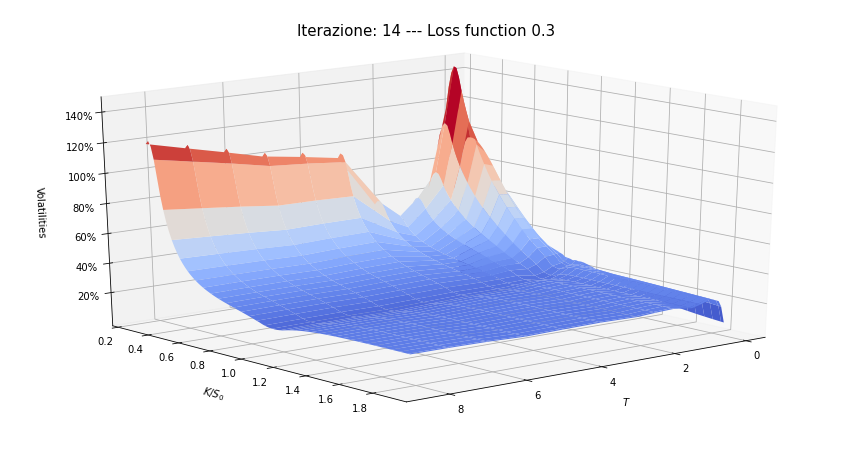

Number of NAN values in prices 0
Number of INF values in prices 0
Number of NAN values 0
Number of INF values 0
Number of NAN values in change of coord 0
Number of INF values in change of coord 0
Number of INF values in sum of loss 0
ELEMENTS []
Iterazione: 15 --- Loss function 0.29---time elapsed: 2.8472728184499827 min


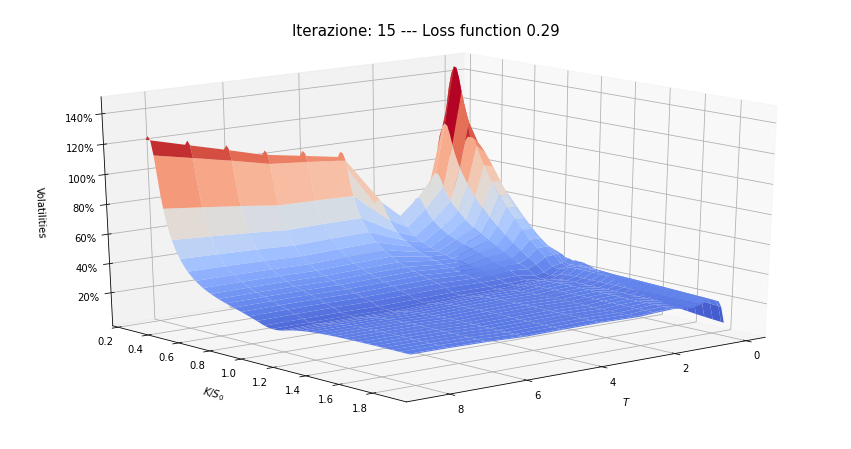

CPU times: user 5min 30s, sys: 9.4 s, total: 5min 39s
Wall time: 2min 51s


In [39]:
%%time
a = Local_Vol_calibrator(market_vola,vola_strikes,vola_maturities,F,L_h=200,L_t=200,precision=0.1)

In [39]:
def forward_volatility(spot_vola_matrix, maturities):
    f_vol = spot_vola_matrix.T[0]
    for i in range(1,len(maturities)):
        f_v = np.sqrt(((spot_vola_matrix.T[i]**2)*maturities[i]-(spot_vola_matrix.T[i-1]**2)*maturities[i-1])/(maturities[i]-maturities[i-1]))
        if i==1:
            f_vol = np.stack((f_vol,f_v),axis=1)
        else:
            f_vol = np.insert(f_vol,len(f_vol.T),f_v,axis=1)
    return f_vol

In [40]:
def figure_stampfw(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
   # plt.savefig("LV_first_forw_"+title+".pdf",bbox_inches='tight')
    plt.show()

In [41]:
def Local_Vol_calibrator_f(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=200,L_t=300,precision=1,max_iter=30):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    market_vola_forward = forward_volatility(market_volatilities, market_maturities)
    print(np.sum(np.isnan(market_vola_forward)))
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, L_h,forward_curve, sigma_LV)
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        IV_coord_forward = forward_volatility(IV_coord, market_maturities)
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord_forward,market_vola_forward)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60)+' min')
        print(np.sum(np.isnan(IV_coord_forward)))
        figure_stampfw(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

0
Iterazione: 1 --- Loss function 4.34---time elapsed: 0.061628193650024816 min
0


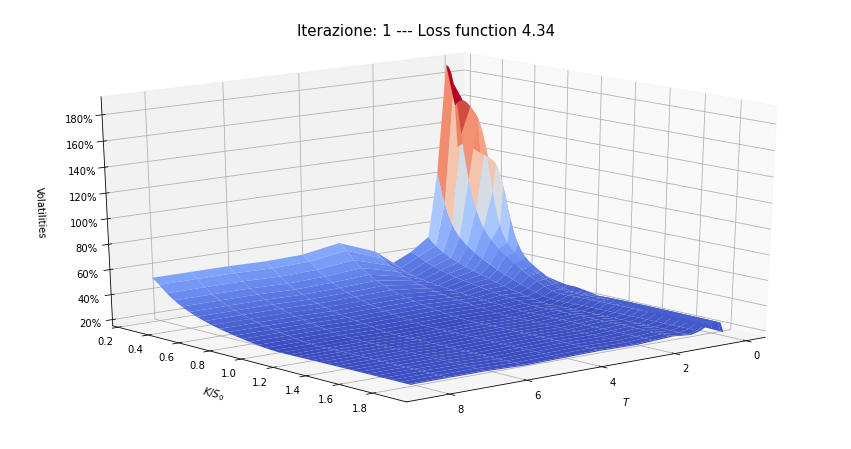

Iterazione: 2 --- Loss function 2.87---time elapsed: 0.12345112973334835 min
0


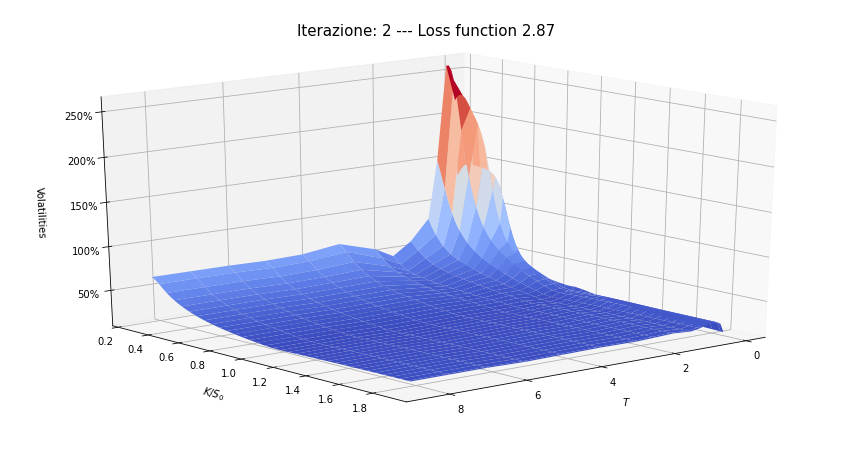

Iterazione: 3 --- Loss function 2.17---time elapsed: 0.18811253215001975 min
0


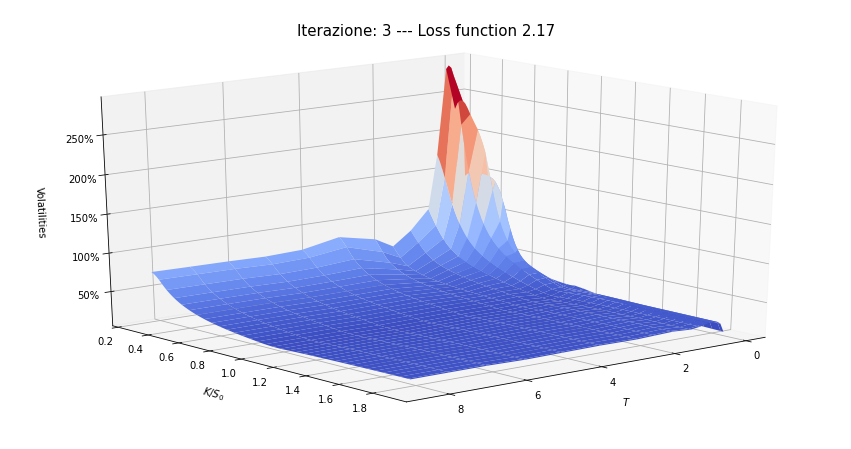

Iterazione: 4 --- Loss function 1.89---time elapsed: 0.2622670180666925 min
0


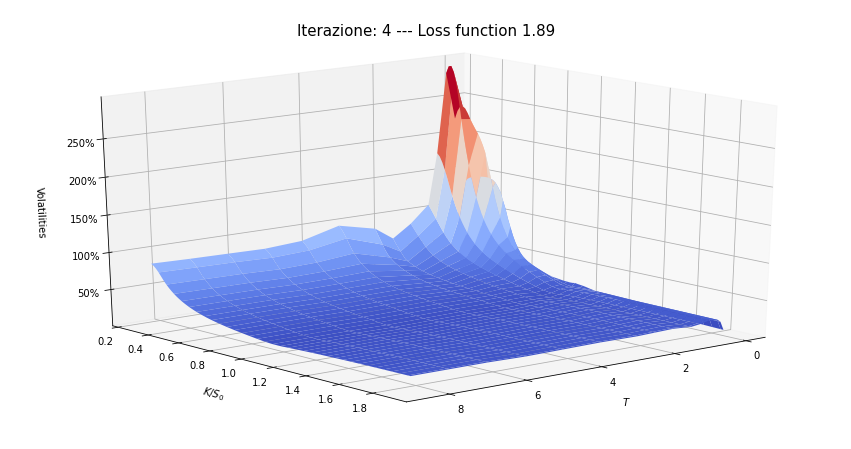

Iterazione: 5 --- Loss function 1.72---time elapsed: 0.3387030925666901 min
0


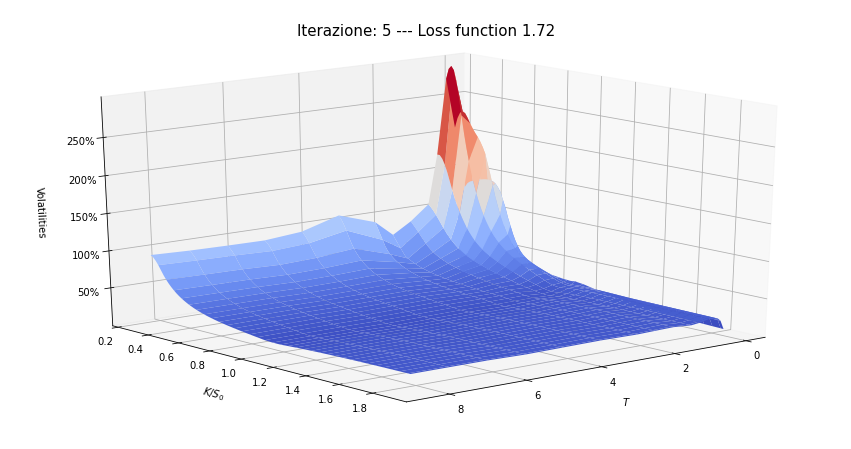

Iterazione: 6 --- Loss function 1.58---time elapsed: 0.40748494916667066 min
0


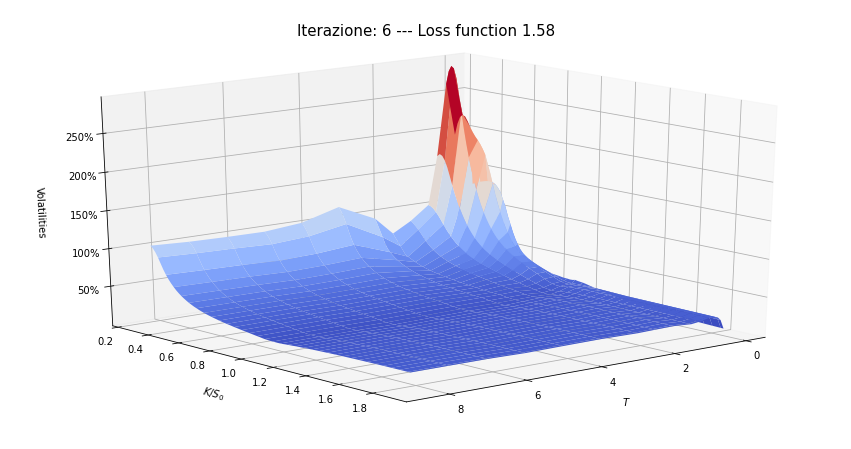

Iterazione: 7 --- Loss function 1.46---time elapsed: 0.48930655311669397 min
0


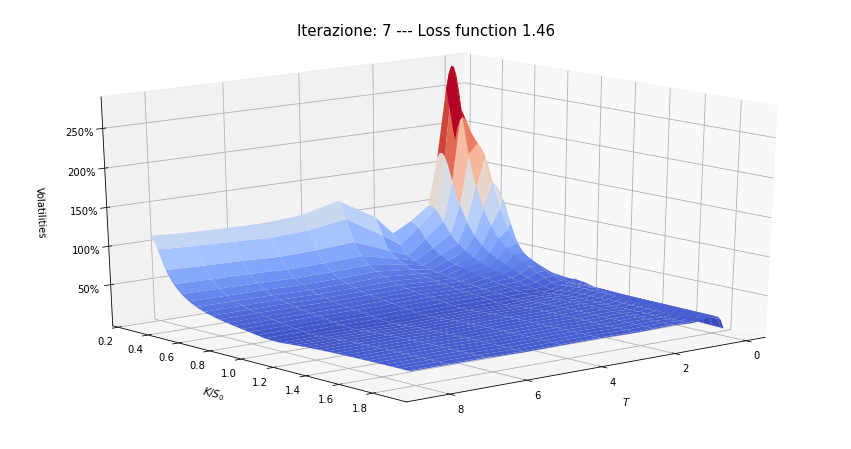

Iterazione: 8 --- Loss function 1.36---time elapsed: 0.5599957711833364 min
0


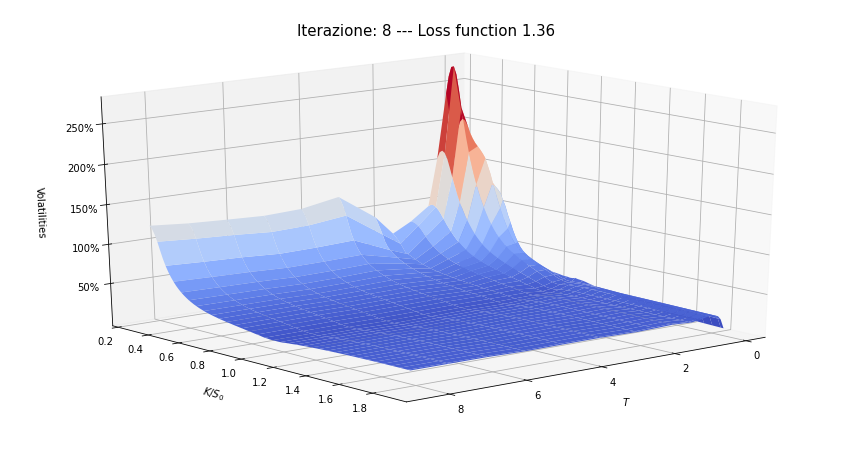

Iterazione: 9 --- Loss function 1.28---time elapsed: 0.6225368677333487 min
0


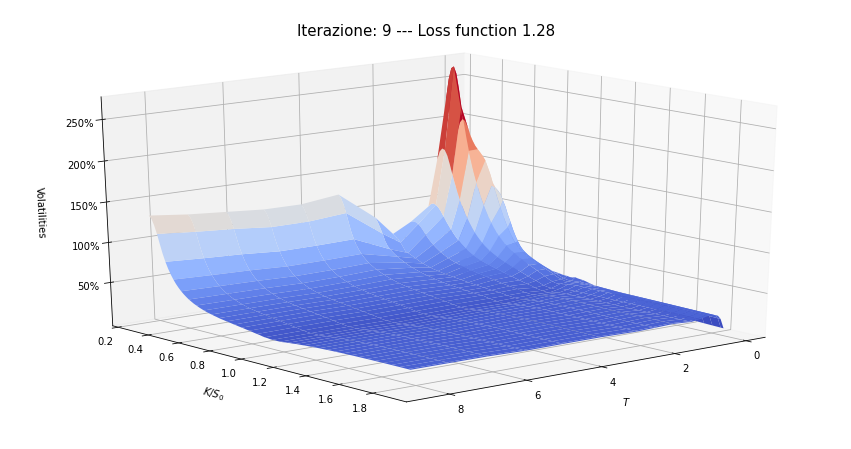

Iterazione: 10 --- Loss function 1.21---time elapsed: 0.6856509510166688 min
0


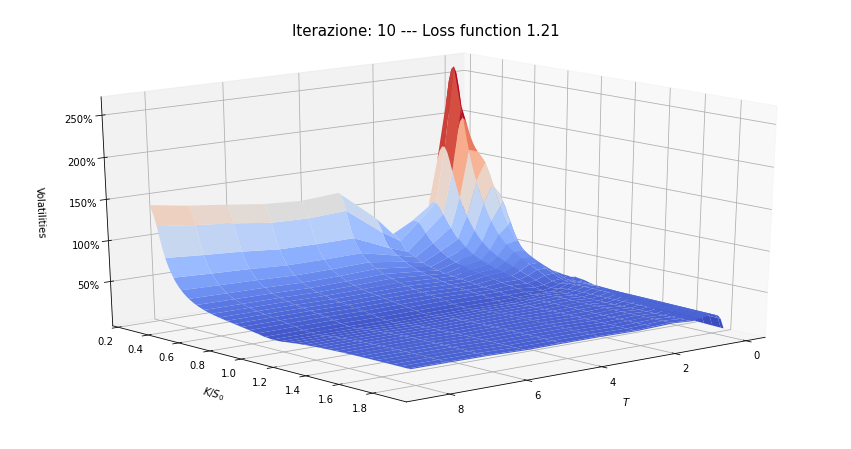

Iterazione: 11 --- Loss function 1.16---time elapsed: 0.747289760783345 min
0


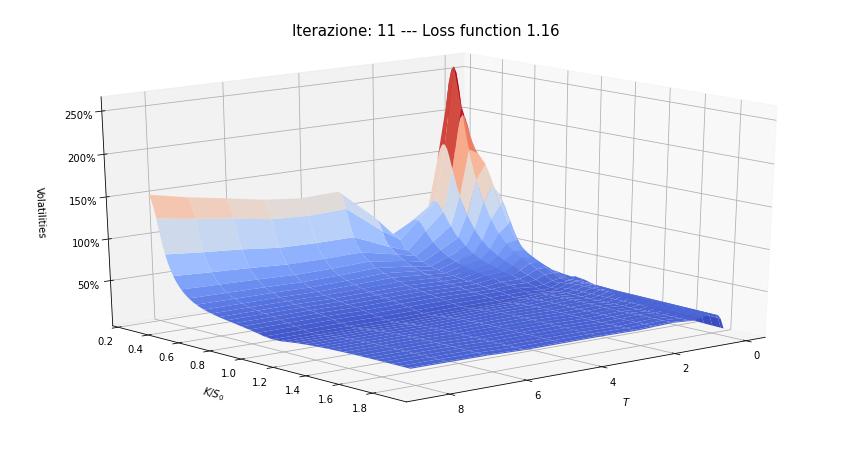

Iterazione: 12 --- Loss function 1.11---time elapsed: 0.8185088421666781 min
0


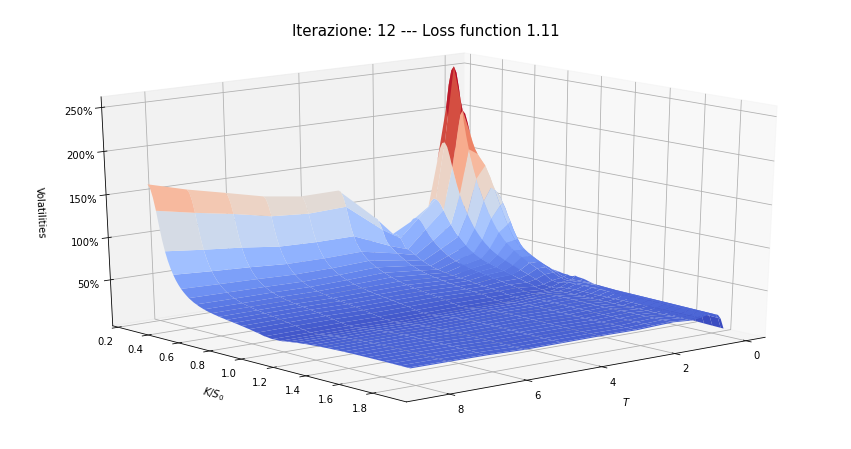

Iterazione: 13 --- Loss function 1.08---time elapsed: 0.8879712616833483 min
0


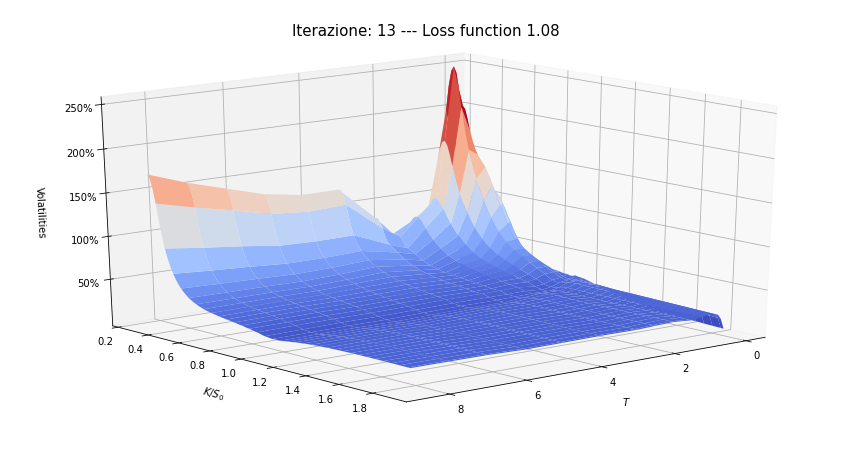

Iterazione: 14 --- Loss function 1.05---time elapsed: 0.9626181557000261 min
0


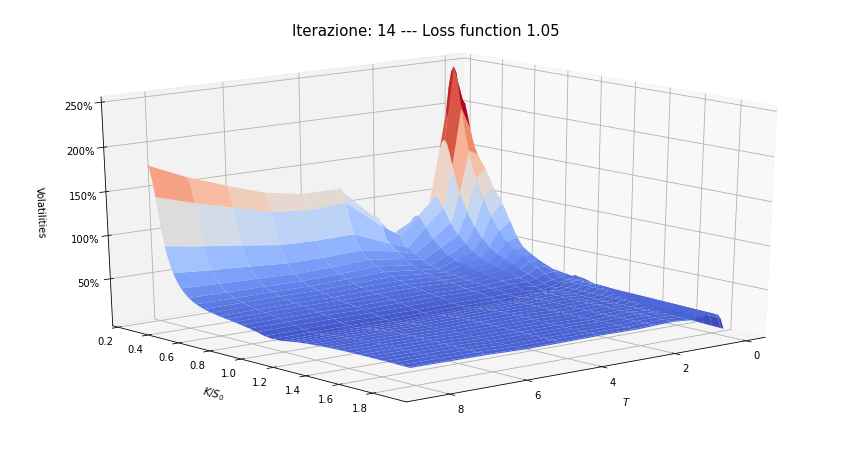

Iterazione: 15 --- Loss function 1.03---time elapsed: 1.045339528100006 min
0


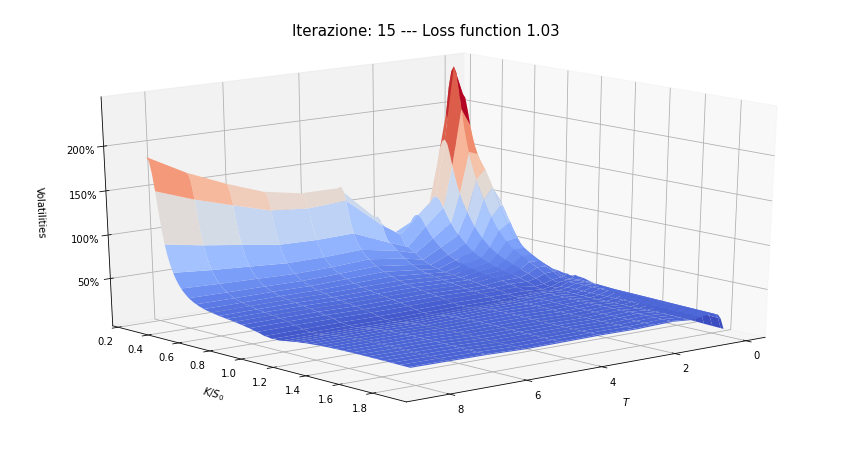

Iterazione: 16 --- Loss function 1.01---time elapsed: 1.134614493450014 min
0


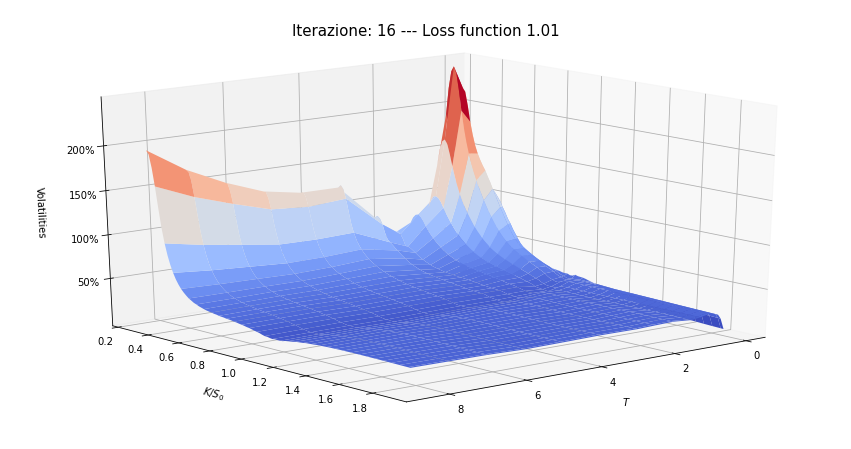

Iterazione: 17 --- Loss function 0.99---time elapsed: 1.2128379404000043 min
0


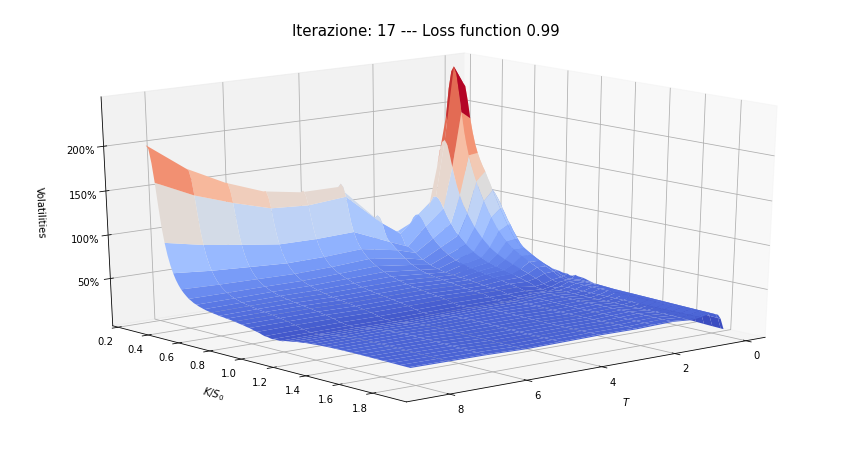

Iterazione: 18 --- Loss function 0.98---time elapsed: 1.2836864585333387 min
0


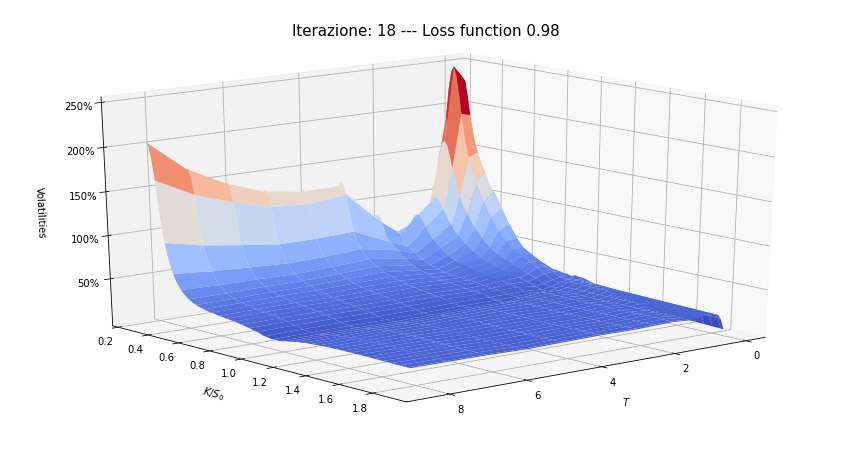

Iterazione: 19 --- Loss function 0.97---time elapsed: 1.3516427743333528 min
0


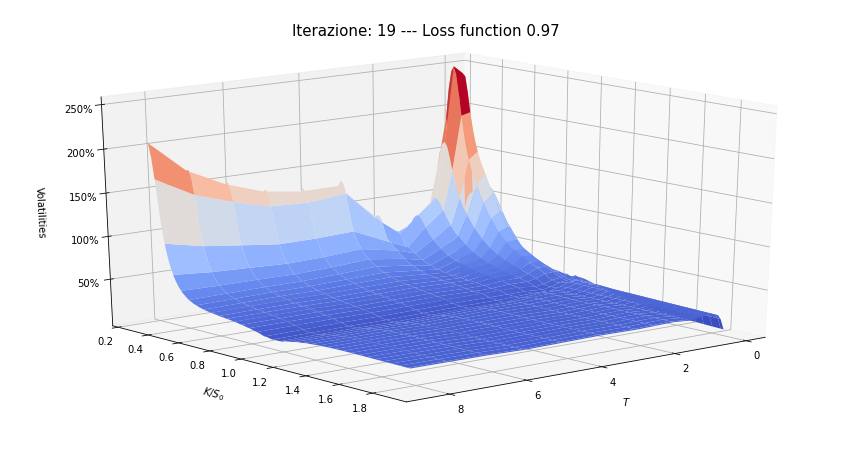

Iterazione: 20 --- Loss function 0.96---time elapsed: 1.427973101083353 min
0


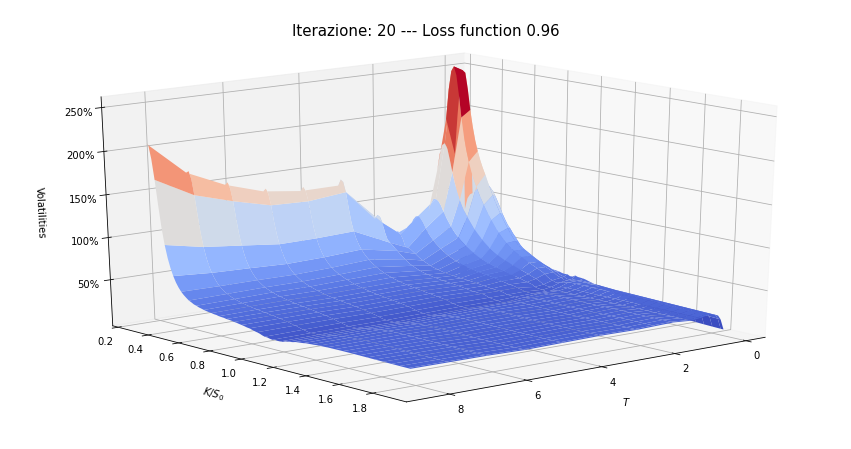

Iterazione: 21 --- Loss function 0.96---time elapsed: 1.5156818740333315 min
0


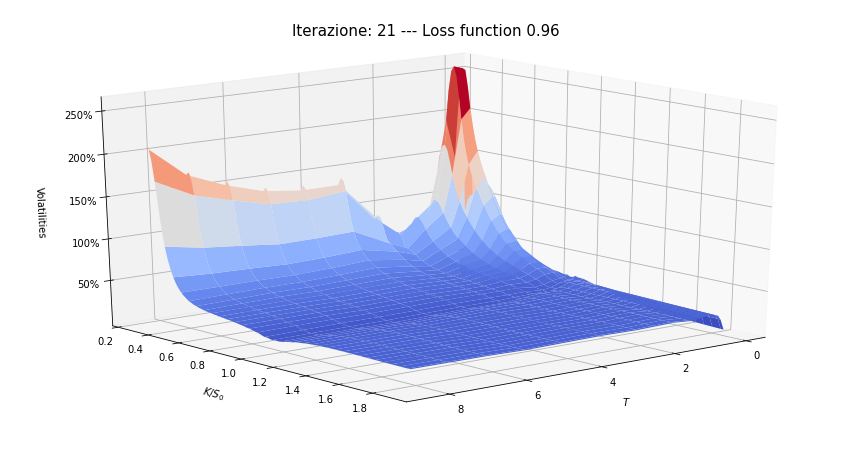

Iterazione: 22 --- Loss function 0.95---time elapsed: 1.586754167533339 min
0


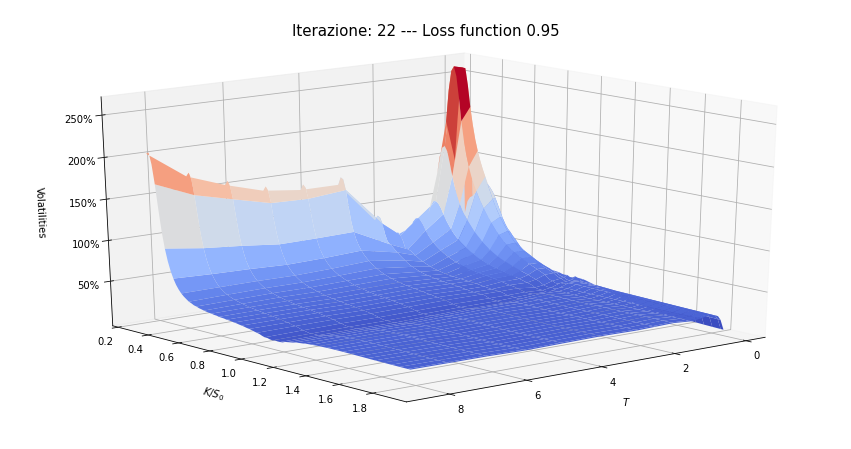

Iterazione: 23 --- Loss function 0.95---time elapsed: 1.6523322077666913 min
0


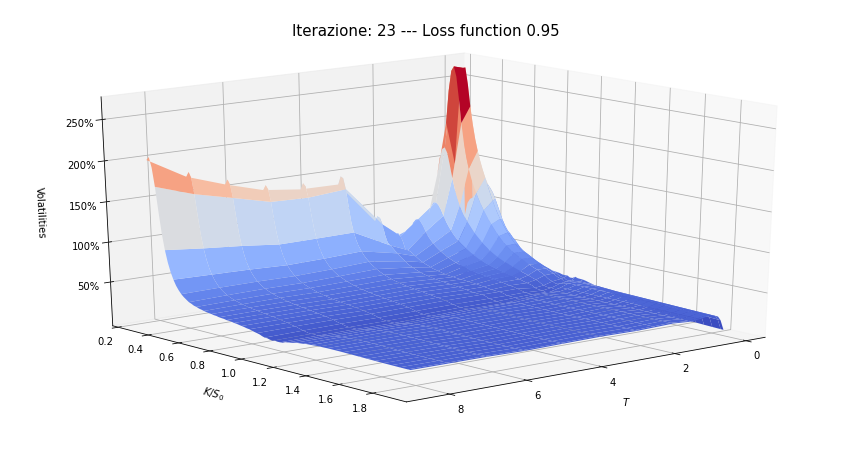

Iterazione: 24 --- Loss function 0.95---time elapsed: 1.7362841532333428 min
0


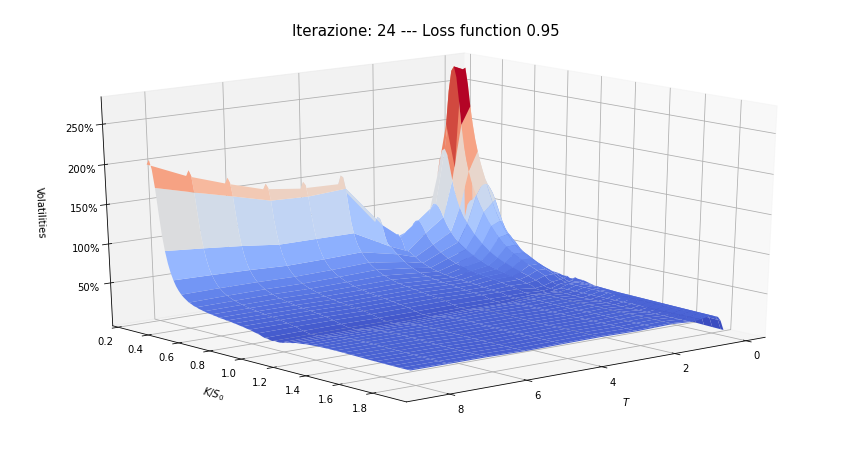

Iterazione: 25 --- Loss function 0.95---time elapsed: 1.8037332015333354 min
0


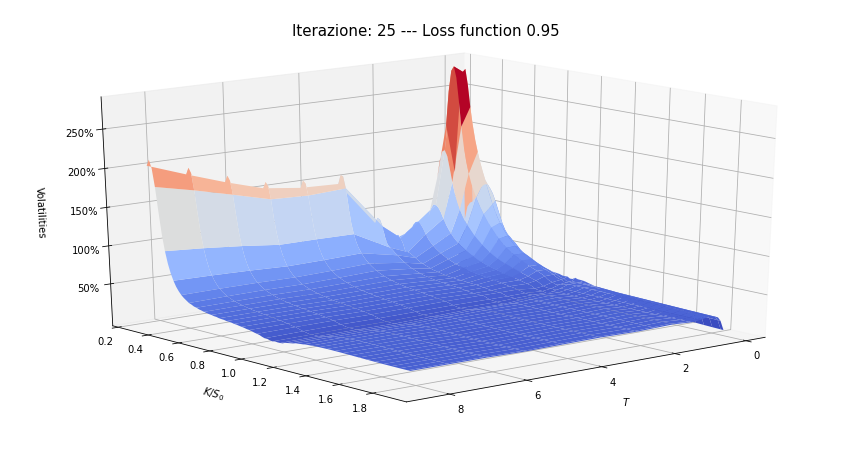

Iterazione: 26 --- Loss function 0.94---time elapsed: 1.8753447248999995 min
0


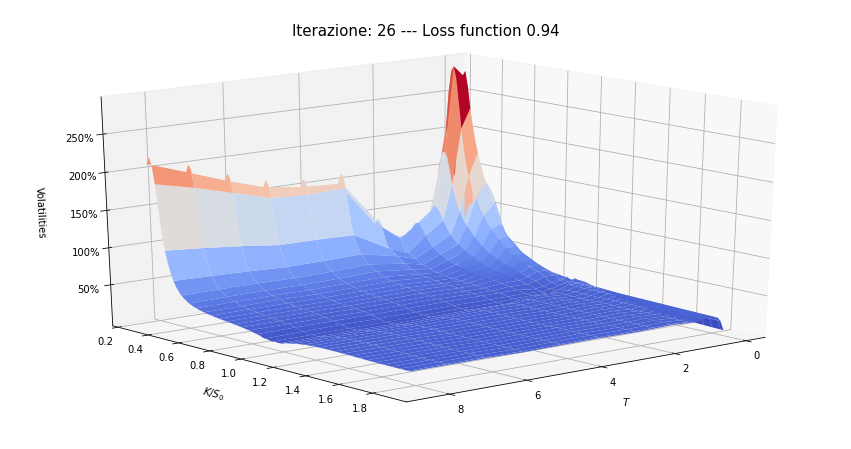

Iterazione: 27 --- Loss function 0.94---time elapsed: 1.9378128350833321 min
0


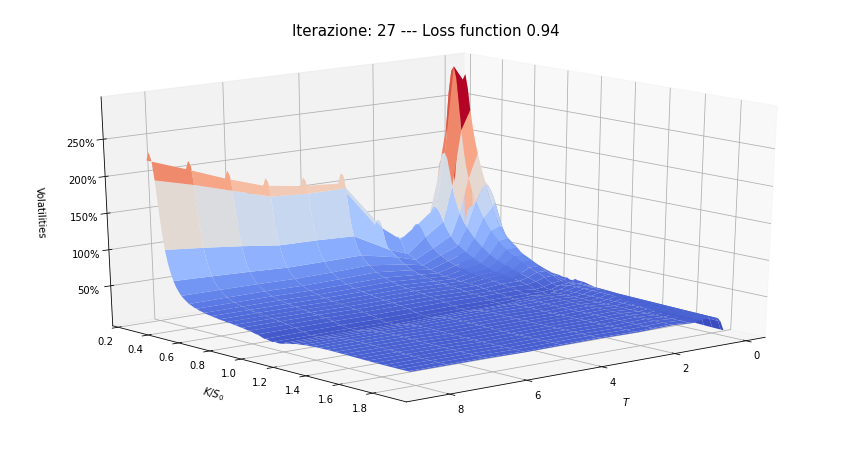

Iterazione: 28 --- Loss function 0.94---time elapsed: 2.009207447516686 min
0


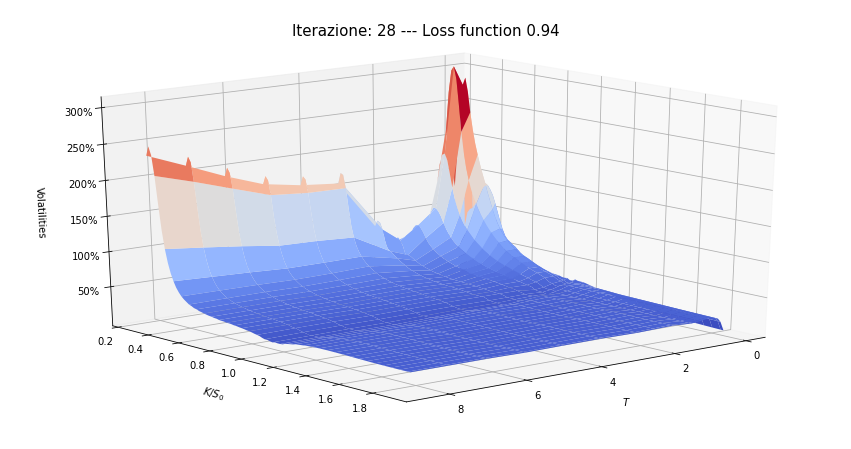

Iterazione: 29 --- Loss function 0.94---time elapsed: 2.083634226083359 min
0


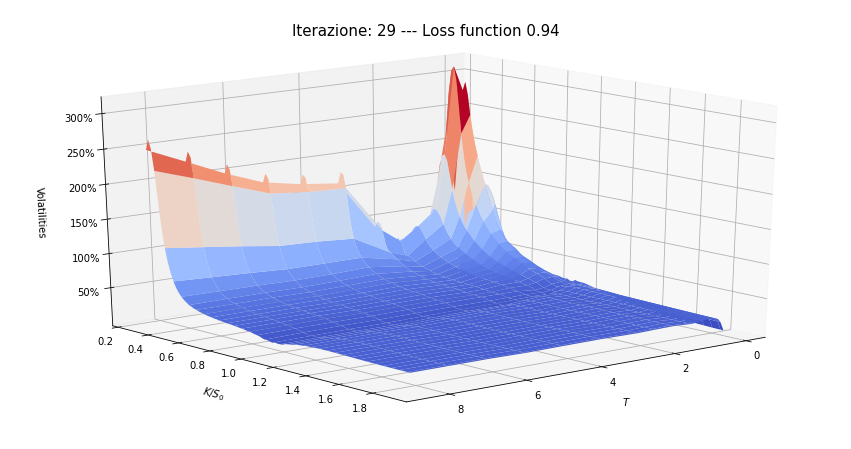

Iterazione: 30 --- Loss function 0.94---time elapsed: 2.154022447783336 min
0


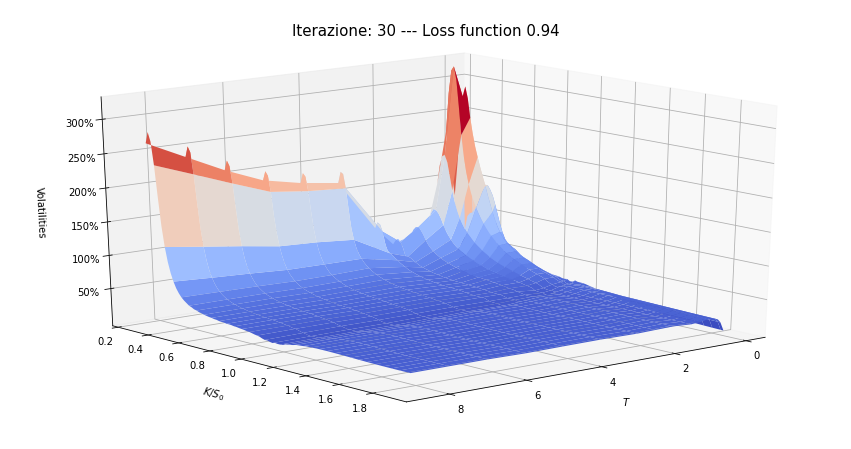

CPU times: user 4min 9s, sys: 7.51 s, total: 4min 16s
Wall time: 2min 9s


In [43]:
%%time
a = Local_Vol_calibrator_f(market_vola,vola_strikes,vola_maturities,F,L_h=150,L_t=100,precision=0.1)

In [44]:
def figure_stampfw_first(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
   # plt.savefig("LV_forw_new_first"+title+".pdf",bbox_inches='tight')
    plt.show()

In [45]:
def Local_Vol_calibrator_f_first(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=200,L_t=300,precision=1,max_iter=15):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    market_vola_forward = forward_volatility(market_volatilities, market_maturities)
    print(np.sum(np.isnan(market_vola_forward)))
    #h_min, h_max = set_limits(market_strikes, market_maturities,forward_curve)
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, L_h,forward_curve, sigma_LV)
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        IV_forward = forward_volatility(IV, market_maturities)
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        IV_coord_forward = back_coordinates(IV_forward,market_maturities,forward_curve,market_strikes,h_grid)
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord_forward,market_vola_forward)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60))
        print(np.sum(np.isnan(IV_coord_forward)))
        figure_stampfw_first(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

0
Iterazione: 1 --- Loss function 5.15---time elapsed: 0.044916362900009214
0


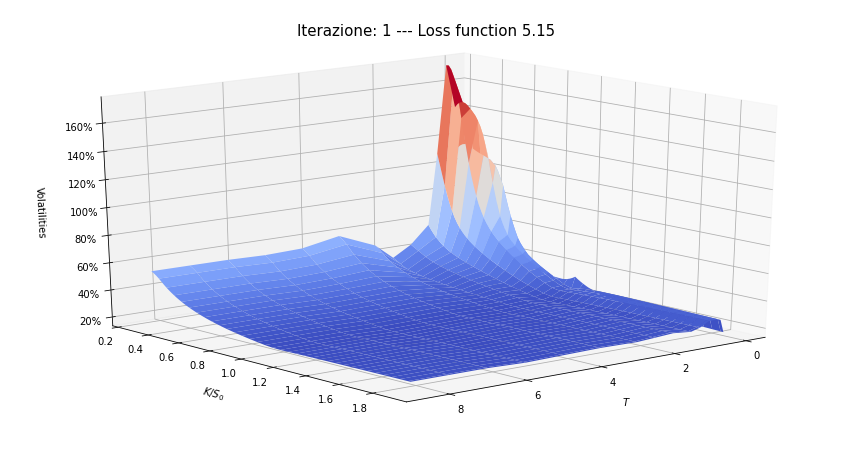

Iterazione: 2 --- Loss function 3.63---time elapsed: 0.0972327030333266
0


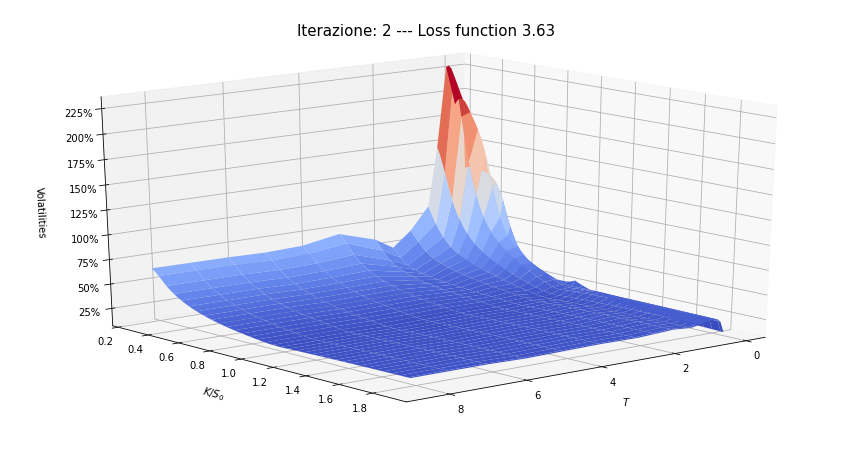

Iterazione: 3 --- Loss function 2.69---time elapsed: 0.14937663978334967
0


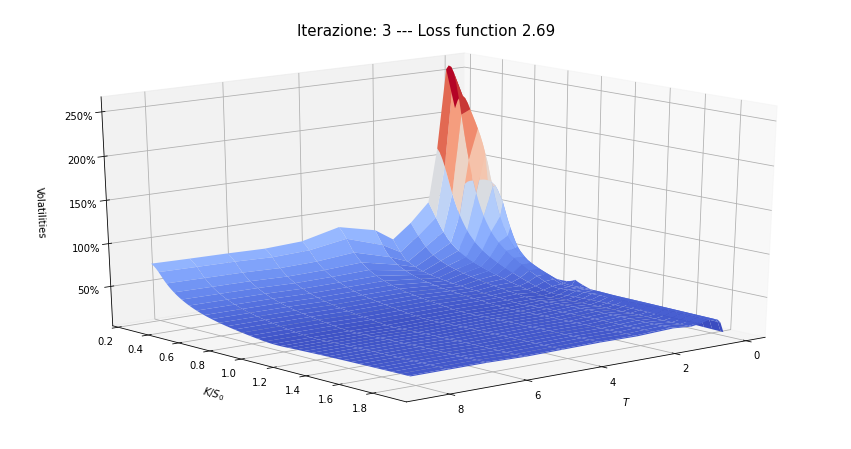

Iterazione: 4 --- Loss function 2.33---time elapsed: 0.20507769446667226
0


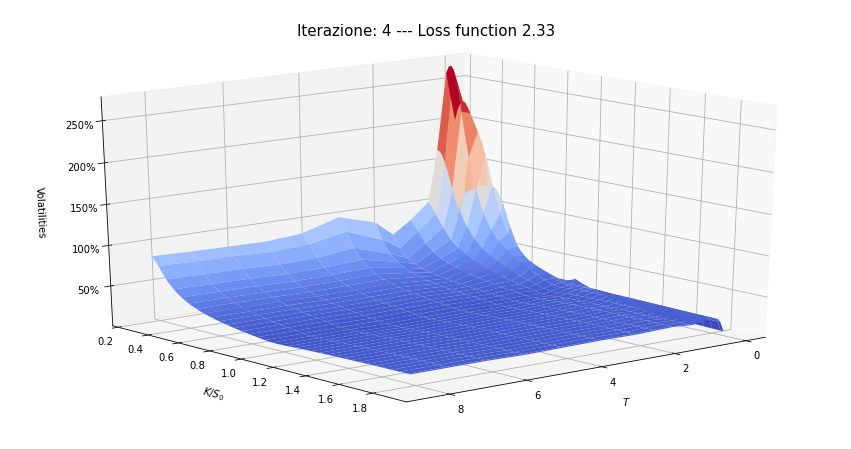

Iterazione: 5 --- Loss function 2.05---time elapsed: 0.25732721091665856
0


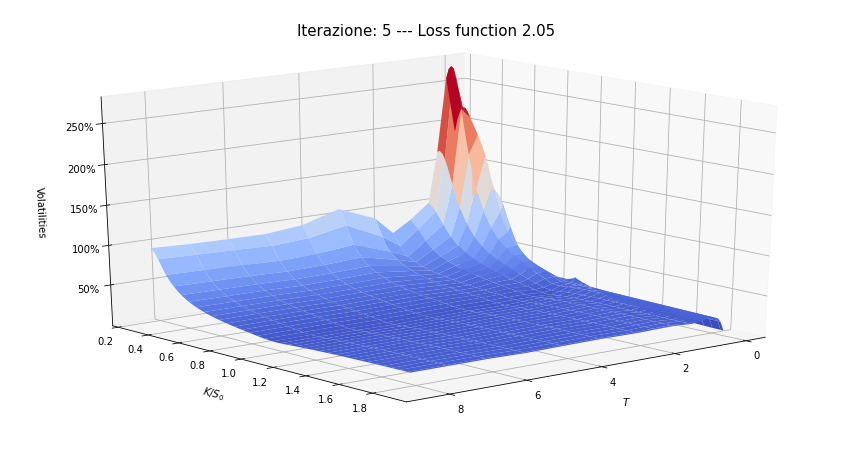

Iterazione: 6 --- Loss function 1.84---time elapsed: 0.3030554794499949
0


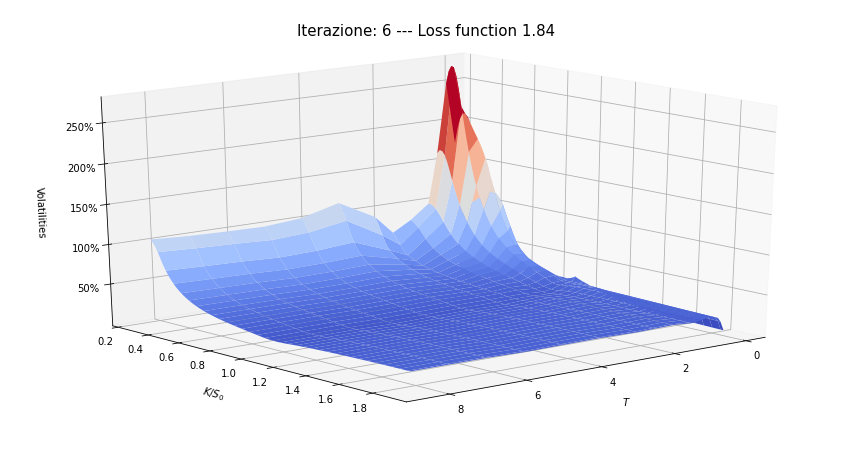

Iterazione: 7 --- Loss function 1.67---time elapsed: 0.34986484525000683
0


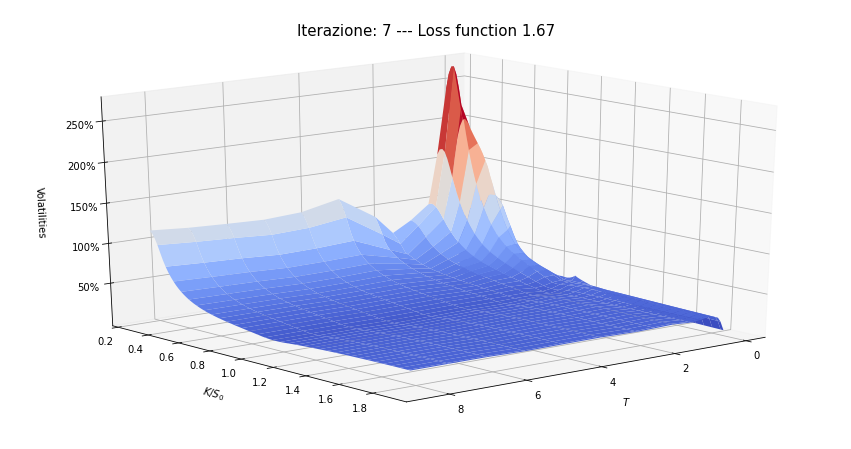

Iterazione: 8 --- Loss function 1.54---time elapsed: 0.3974876526666776
0


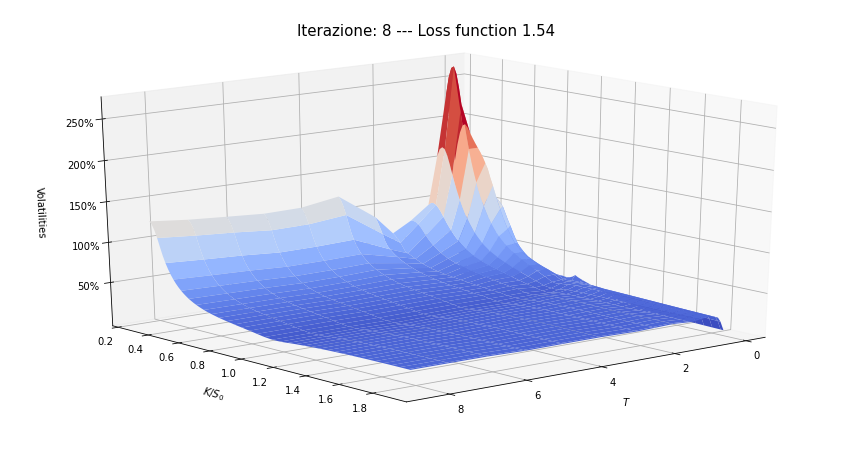

Iterazione: 9 --- Loss function 1.43---time elapsed: 0.4572236952500134
0


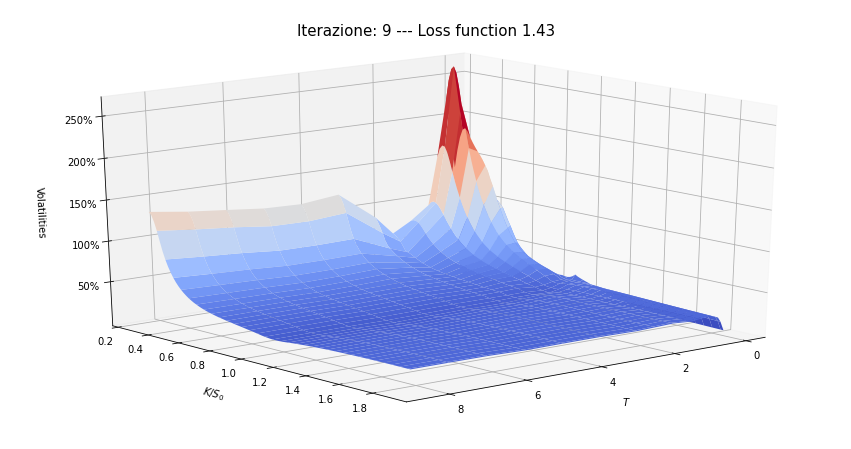

Iterazione: 10 --- Loss function 1.34---time elapsed: 0.5076991176500087
0


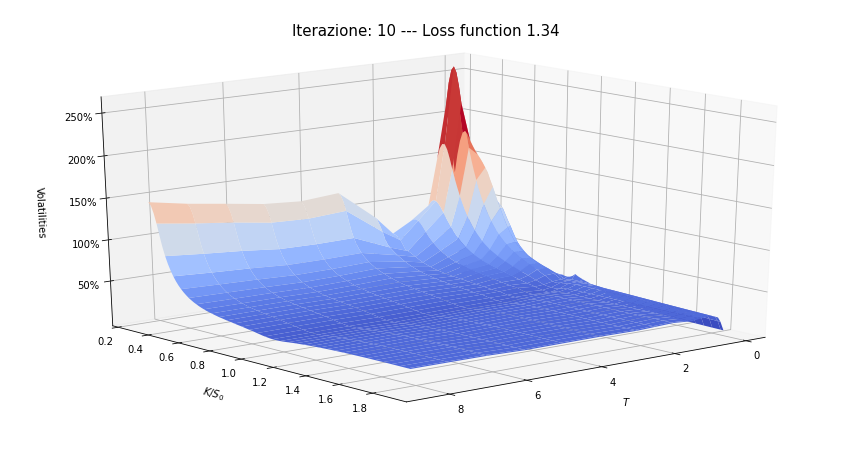

Iterazione: 11 --- Loss function 1.26---time elapsed: 0.56226788736667
0


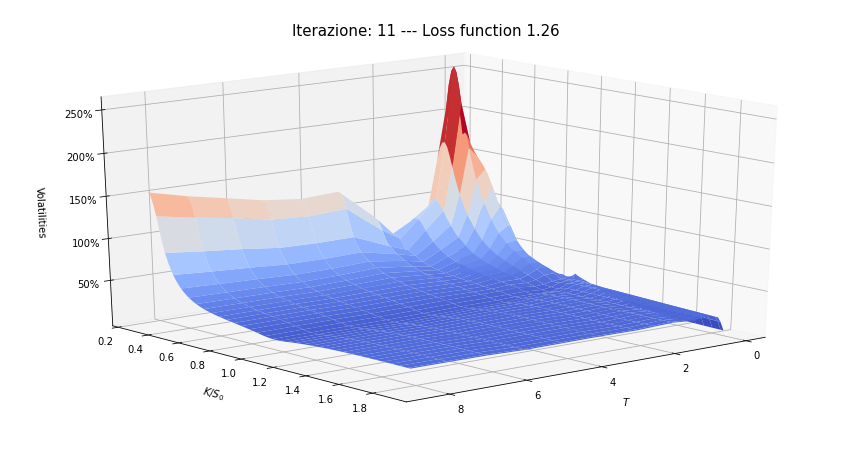

Iterazione: 12 --- Loss function 1.2---time elapsed: 0.6219892826333308
0


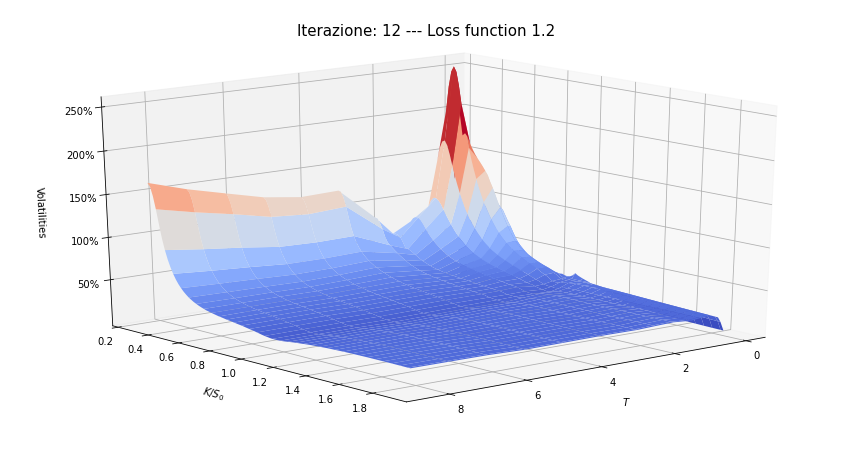

Iterazione: 13 --- Loss function 1.16---time elapsed: 0.6886890980166754
0


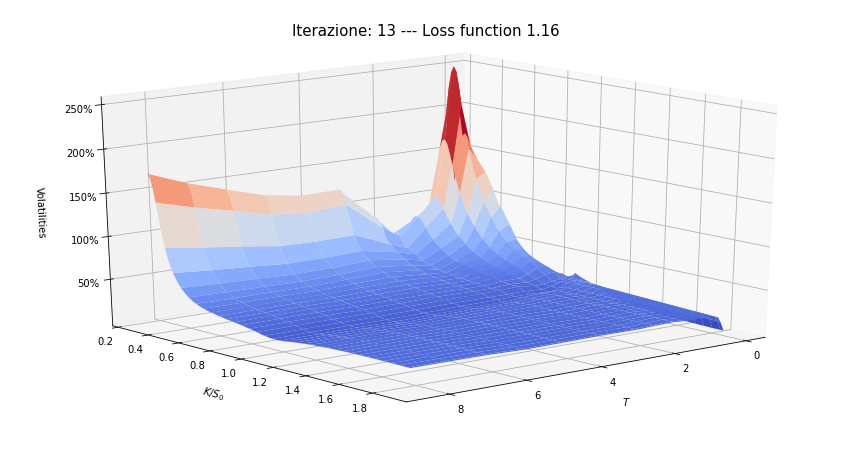

Iterazione: 14 --- Loss function 1.12---time elapsed: 0.7363819457166756
0


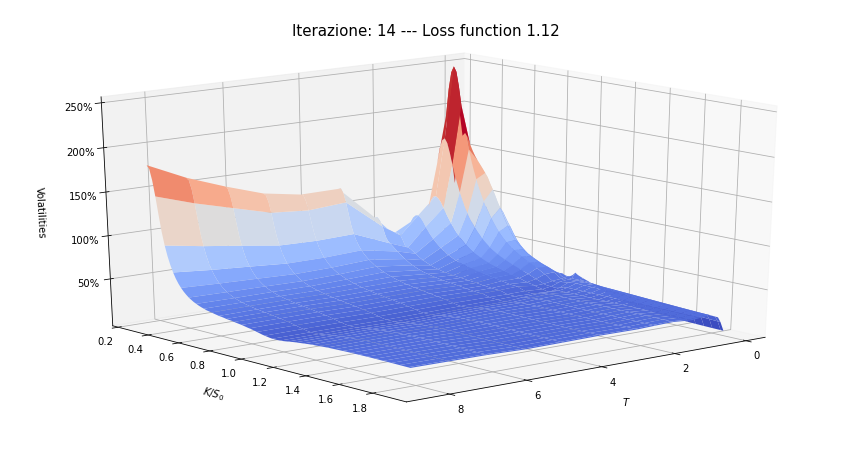

Iterazione: 15 --- Loss function 1.08---time elapsed: 0.7880312611833384
0


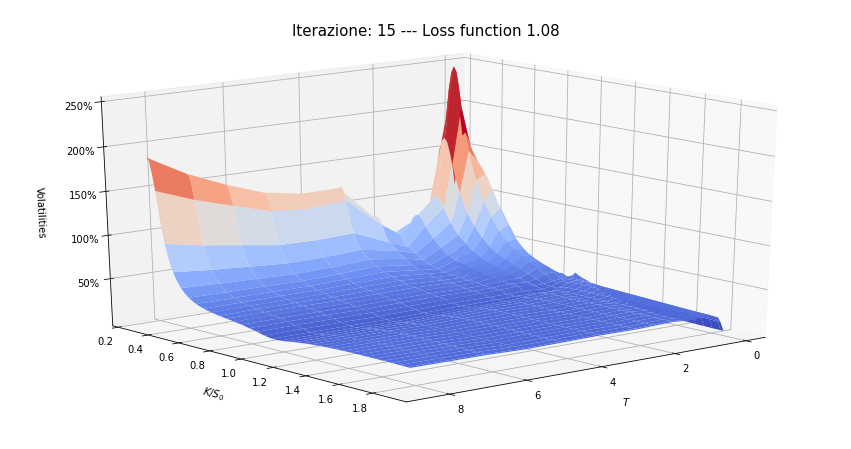

CPU times: user 1min 31s, sys: 2.96 s, total: 1min 34s
Wall time: 47.5 s


In [47]:
%%time
a = Local_Vol_calibrator_f_first(market_vola,vola_strikes,vola_maturities,F,L_h=100,L_t=100,precision=0.1)